# Climate Analysis: Honolulu, HI 

* The purpose of this project and analysis is to plan for a fictitious vacation in Honolulu, HI based on climate data recorded at stations in the area.


* Utilize Python and SQLAlchemy to do basic climate analysis and data exploration of the climate database. All of the following analysis is completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.


* Utilizes VSCode to create Flask API for queries developed in this notebook. (Please refer to app.py for code and additional information.)

## Import Dependencies & Plot Styles

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Inspect all columns and dtypes for measurement.
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Inspect all columns and dtypes for station.
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

## Precipitation Analysis

In [12]:
# Query the most recent date in dataset.
# Convert to datetime object for calculation below.
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(1).all()
max_date = max_date[0][0]
max_date = dt.datetime.strptime(max_date, "%Y-%m-%d")
max_date

datetime.datetime(2017, 8, 23, 0, 0)

In [13]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = max_date - dt.timedelta(days=366)
year_ago

datetime.datetime(2016, 8, 22, 0, 0)

In [15]:
# Perform a query to retrieve the last 12 months of precipitation data.
precipitations = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
        filter(func.strftime("%Y-%m-%d", Measurement.date) >= year_ago).all()
precipitations

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_precipitation = pd.DataFrame(precipitations, columns=['Date', 'Precipitation'])
# df_precipitation

# Dataframe sorted by date, set index to date.
df_precipitation = df_precipitation.sort_values(by = 'Date')
df_precipitation.set_index('Date', inplace=True)
df_precipitation.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [17]:
df_precipitation.tail()

,Precipitation
Date,
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45


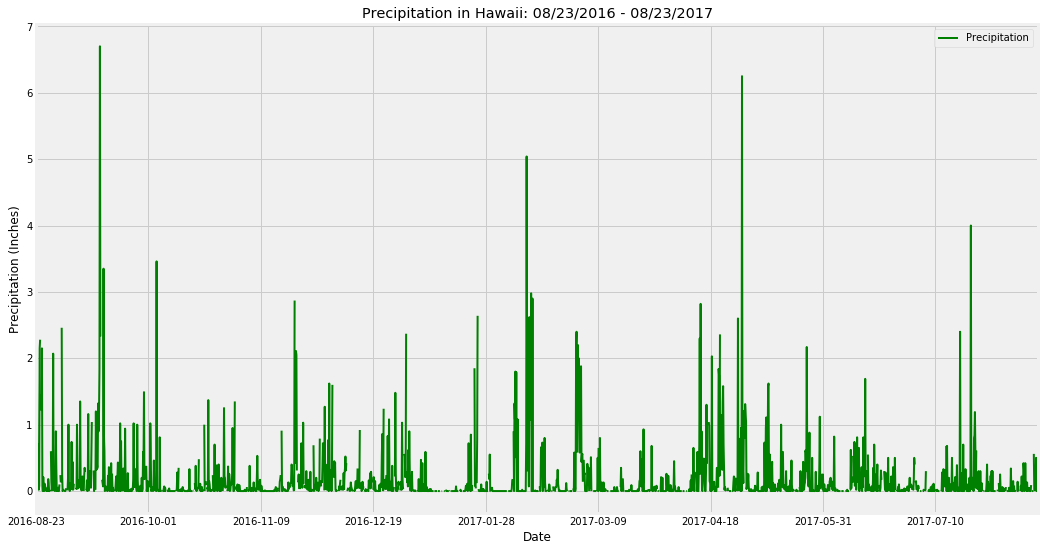

In [26]:
# Use Pandas Plotting with Matplotlib to plot the data
df_precipitation.plot(figsize = (16, 9), sort_columns=True, legend=True, color='g', linewidth=2)
plt.ylabel('Precipitation (Inches)')
plt.xlabel('Date')
plt.grid(True)
plt.title("Precipitation in Hawaii: 08/23/2016 - 08/23/2017")
plt.savefig('Images/precipitation_plot.png')
plt.show()

In [27]:
# Calculate the summary statistics for the precipitation data
df_precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [28]:
# Query to show how many stations are available in this dataset.
station_count = session.query(Station.id).count()
station_count

9

In [29]:
# Lists the most active stations from Station DB and their respective count.
# Merge on "station" for Measurement and Station tables.
# Group By Station and list station and counts in Desc order.
most_active_stations = session.query(Station.station, func.count(Station.id)).\
    filter(Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Station.id).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Locate the most active station id.
most_active_station = most_active_stations[0][0]
most_active_station

'USC00519281'

In [31]:
# Using the most active station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature.
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
summary_temps

[(54.0, 85.0, 71.66378066378067)]

In [32]:
# Choose the station with the highest number of temperature observations
# and query the last 12 months of temp observations.
temperatures = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= year_ago).all()
temperatures

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [33]:
# Load 12 months of temp. data for most active station into Pandas DF.
# Set index to Date.
df_temperature = pd.DataFrame(temperatures, columns=['Date', 'Temperature'])
df_temperature.set_index('Date', inplace=True)
df_temperature.head()

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


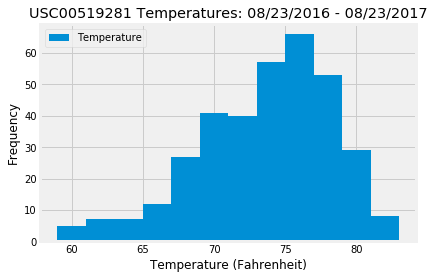

In [34]:
# Plot results for Station USC00519281 as histogram with 12 bins.
fig, ax = plt.subplots()
df_temperature.plot.hist(bins = 12, ax = ax, legend=True)

# Set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title('USC00519281 Temperatures: 08/23/2016 - 08/23/2017')

# Save figure
plt.savefig("Images/temperature_histogram.png")
plt.show()

### Temperature Analysis For Trip: 07/28/2017 - 08/05/2017

In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [125]:
# Use previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for trip using the previous year's data for those same dates.
# Trip dates = 2017-07-28 - 2017-08-05: Utilize available data from 2017.
start_date = '2017-07-28'
end_date = '2017-08-05'
trip_temperatures = calc_temps(start_date, end_date)
trip_temperatures

[(72.0, 79.11363636363636, 84.0)]

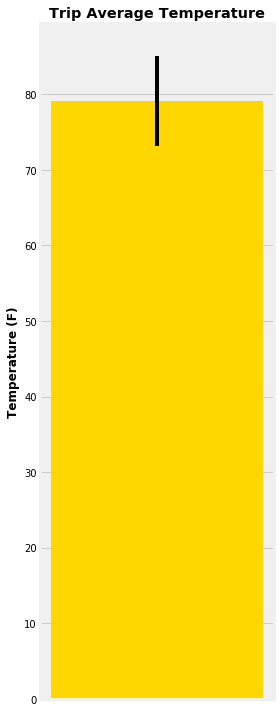

In [126]:
# Plot the results from previous query as a bar chart. 
# Use "Trip Avg Temp" as  Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Set avg temp to variable called tavg.
tavg = trip_temperatures[0][1]

# Set peak-to-peak (yerr) to variable (calculated as difference between max and min / 2) as avg tmax_tmin.
tmax_tmin = (trip_temperatures[0][2] - trip_temperatures[0][0])/2

# Plot results as bar chart.
fig, ax = plt.subplots(figsize = (4, 10))

ax.bar(1, tavg, yerr = tmax_tmin, width = 0.5, color = 'gold')

# Set ticks and labels.
ax.set_xticks([])
ax.set_title("Trip Average Temperature", weight = 'bold')
ax.set_ylabel("Temperature (F)", weight = 'bold')

plt.tight_layout()
plt.savefig("Images/trip_avg_temp.png")
plt.show()

## Daily Rainfall Average

In [129]:
# Query total amount of rainfall per station for trip dates.
# Format required field into list to select all in query.
selection = ([
    Station.station,
    Station.name,
    func.sum(Measurement.prcp),
    Station.latitude,
    Station.longitude,
    Station.elevation
])

# Query for selection, merge on "station", for range start/end dates.
# Group by station and order by precipitation amount descending.
trip_prcptotals = session.query(*selection).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()

trip_prcptotals

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  1.31,
  21.3331,
  -157.8025,
  152.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.38,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.38,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 0.19, 21.4234, -157.8015, 14.6),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.04, 21.2716, -157.8168, 3.0),
 ('USC00517948', 'PEARL CITY, HI US', 0.01, 21.3934, -157.9751, 11.9),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.0,
  21.33556,
  -157.71139,
  19.5)]

In [130]:
df_trip_prcptotals = pd.DataFrame(trip_prcptotals, columns=["station", "name", "total_prcp", "lat", "lng", "elevation"])
df_trip_prcptotals

,station,name,total_prcp,lat,lng,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.31,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.38,21.52130,-157.83740,7.0
2,USC00519281,"WAIHEE 837.5, HI US",0.38,21.45167,-157.84889,32.9
3,USC00513117,"KANEOHE 838.1, HI US",0.19,21.42340,-157.80150,14.6
4,USC00519397,"WAIKIKI 717.2, HI US",0.04,21.27160,-157.81680,3.0
5,USC00517948,"PEARL CITY, HI US",0.01,21.39340,-157.97510,11.9
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5


## Daily Normals for Trip: 07/28/2019 - 08/05/2019

In [131]:
# Query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [139]:
# Create list to hold each month-day for trip.
dates = ['07-28', '07-29', '07-30', '07-31', '08-01', '08-02', '08-03', '08-04', '08-05']

# Create empty list to hold all normals for trip.
normals = []

# Loop through each date in dates, save all info for normals in empty dict called daily_norm.
# Add trip Year (2019) to date string, calculate daily normal, and append all info to dict, then to normals list.
for date in dates:
    daily_norm = {}
    daily_normal = daily_normals(date)
    daily_norm['date'] = "2019-" + date
    daily_norm['tmin'] = daily_normal[0][0]
    daily_norm['tavg'] = round(daily_normal[0][1], 2)
    daily_norm['tmax'] = daily_normal[0][2]
    normals.append(daily_norm)
    
normals

[{'date': '2019-07-28', 'tmin': 69.0, 'tavg': 76.46, 'tmax': 82.0},
 {'date': '2019-07-29', 'tmin': 69.0, 'tavg': 76.47, 'tmax': 83.0},
 {'date': '2019-07-30', 'tmin': 69.0, 'tavg': 77.35, 'tmax': 84.0},
 {'date': '2019-07-31', 'tmin': 72.0, 'tavg': 77.04, 'tmax': 83.0},
 {'date': '2019-08-01', 'tmin': 67.0, 'tavg': 75.54, 'tmax': 83.0},
 {'date': '2019-08-02', 'tmin': 68.0, 'tavg': 75.6, 'tmax': 84.0},
 {'date': '2019-08-03', 'tmin': 70.0, 'tavg': 76.61, 'tmax': 85.0},
 {'date': '2019-08-04', 'tmin': 69.0, 'tavg': 76.71, 'tmax': 84.0},
 {'date': '2019-08-05', 'tmin': 69.0, 'tavg': 76.15, 'tmax': 82.0}]

In [153]:
# Load normals into Dataframe and set index to date.
df_trip_normals = pd.DataFrame(normals)
df_trip_normals = df_trip_normals.set_index('date')
df_trip_normals

,tavg,tmax,tmin
date,,,
2019-07-28,76.46,82.0,69.0
2019-07-29,76.47,83.0,69.0
2019-07-30,77.35,84.0,69.0
2019-07-31,77.04,83.0,72.0
2019-08-01,75.54,83.0,67.0
2019-08-02,75.60,84.0,68.0
2019-08-03,76.61,85.0,70.0
2019-08-04,76.71,84.0,69.0
2019-08-05,76.15,82.0,69.0


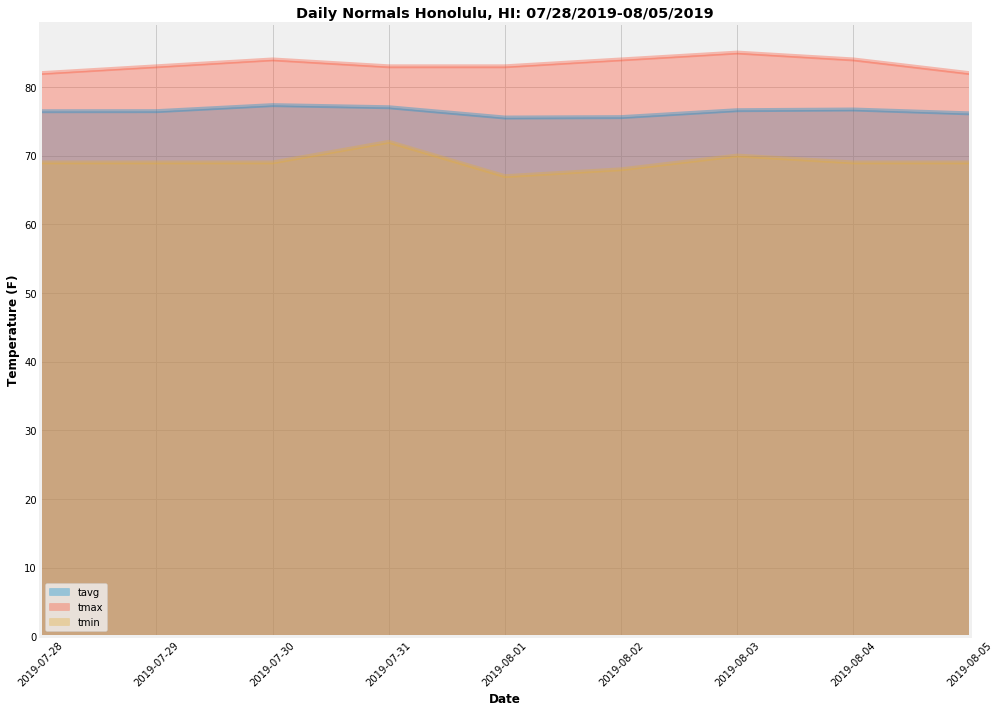

In [171]:
# Plot an area plot (stacked=False) for the daily normals.
fig, ax = plt.subplots(figsize = (14, 10))
df_trip_normals.plot.area(ax = ax, stacked = False, alpha=.35)

# Set labels and ticks.
ax.set_xlabel('Date', weight = 'bold')
ax.set_ylabel('Temperature (F)', weight = 'bold')
ax.set_title('Daily Normals Honolulu, HI: 07/28/2019-08/05/2019', weight = 'bold')
plt.xticks(rotation=45)

plt.savefig('Images/daily_normals.png')

plt.tight_layout()
plt.show()